# TO READ 
To run this implementation you will need to install 
- numpy 
- sklearn
- pandas
- matplotlib
- cvxpy 

For instance with pip, run from the terminal the command line : pip install numpy 


You will also need a MOSEK licence. Personal academic license may be requested [here](https://www.mosek.com/license/request/?i=acp). Alternatively, you can change the solver in the MaxEnt class implementation and in the cells where an optimization program is solved.

# DATASET STUDENT 

Classification for which the task is to determine wheter a student is going to pass (1) or is going to fail (0) a math class. The sensible attribute is gender which is binary : female (0) male (1).

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np 
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from scipy import stats
import math
import matplotlib.colors as mcolors
import matplotlib.cm as cm

Directory in which the graphs should be saved. If the directory does not exist, an error will occur. 

WARNING : Make sur this path exists. Alternatively, but there are numerous, comment all the <i>plt.savefig('')</i> lines. 

In [2]:
gdir = "img/STUDENT/"

Importing the data from csv file, X is the data matrix, Y is the target matrix and Z is the matrix containing the sensible attribute. 

In [3]:
X_raw=pd.read_csv("data/student/student-mat.csv",sep=';')
X_raw.insert(0,'bias',1)
Y = np.expand_dims(((X_raw['G3'])>10)*1,axis=1)
Z = np.expand_dims((X_raw['sex']=='M')*1,axis=1)
X = X_raw.drop(labels=['G3','G1','G2','sex'],axis=1)
X = pd.get_dummies(X)

In [4]:
a = np.count_nonzero(Y==0)
b = np.count_nonzero(Y==1)
print("prior target: {} - {}".format(a/(a+b),b/(a+b)))

prior target: 0.4708860759493671 - 0.529113924050633


In [5]:
a = np.count_nonzero(Z==0)
b = np.count_nonzero(Z==1)
print("prior protected group: {} - {}".format(a/(a+b),b/(a+b)))

prior protected group: 0.5265822784810127 - 0.47341772151898737


In [6]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 34 columns):
bias          395 non-null int64
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 no

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 55 columns):
bias                 395 non-null int64
age                  395 non-null int64
Medu                 395 non-null int64
Fedu                 395 non-null int64
traveltime           395 non-null int64
studytime            395 non-null int64
failures             395 non-null int64
famrel               395 non-null int64
freetime             395 non-null int64
goout                395 non-null int64
Dalc                 395 non-null int64
Walc                 395 non-null int64
health               395 non-null int64
absences             395 non-null int64
school_GP            395 non-null uint8
school_MS            395 non-null uint8
address_R            395 non-null uint8
address_U            395 non-null uint8
famsize_GT3          395 non-null uint8
famsize_LE3          395 non-null uint8
Pstatus_A            395 non-null uint8
Pstatus_T            395 non-null uint8
Mjob_at_home   

Functions to calculate correlation, covariance and variance

In [8]:
def covariance(x,y): 
    if x.ndim == 1: 
        x=np.expand_dims(x,axis=1)
    if y.ndim == 1: 
        y=np.expand_dims(y,axis=1)
    nx,_ = x.shape
    ny,_ = y.shape
    if nx != ny: 
        raise ValueError("Dimension mismatch {} != {}".format(nx,ny))
    H = np.eye(nx)-1./nx*np.ones((nx,nx))
    return 1./(nx-1)* (np.transpose(H@y)@x) 
def variance(x):
    res=covariance(x,x)[0,0]
    if res<0 and abs(res)>1e-3: 
        raise ValueError("Negative variance, how come? {}".format(res))
    return abs(res)
def correlation(x,y):
    return covariance(x,y)/math.sqrt(variance(x)*variance(y))
    
def projection(X,verbose=0):
    Z = np.expand_dims(X[:,-1],axis=1)
    n = Z.shape[0]
    m = Z.ndim
    H = np.eye(n)-1/n*(np.ones((n,n)))
    HZ = H@Z
    try : 
        inverse = np.linalg.inv(np.dot(np.transpose(HZ),HZ))
    except np.linalg.LinAlgError:
        if(m==1):
            inverse = 1/np.dot(np.transpose(HZ),HZ)
    op = HZ @ np.transpose(HZ)*inverse
    I = np.eye(n)
    op_orth = I-op
    op_orth.shape
    X_proj = op_orth@X
    if verbose == 1 : 
        print("COVARIANCE\n {}".format(covariance(X_proj,Z)))
        print("CORRELATION\n {}".format(correlation(X_proj[:,0],Z[:,0])))
    return np.concatenate((X_proj,Z),axis=1)


Splitting the dataset into a train set and test set. Although for most experiments there is no hyperparameter to fit and we could have cross validated on the whole dataset, some will need a test set to avoid statistical mistakes. 

In [9]:
############################ Splitting, scaling and normalizing ############################

X_train, X_test, y_train, y_test = train_test_split(np.concatenate((X, Z), axis=1), Y, test_size=0.25,random_state=1)
scaler = StandardScaler()
normer = MinMaxScaler()
scaler.fit(X_train)
normer.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_norm = normer.transform(X_train)
X_test_norm = normer.transform(X_test)
X_train_scaled[:,0]=1 #When scaling the bias column gets filled with 0, we need it to remain 1!
X_test_scaled[:,0]=1 #When scaling the bias column gets filled with 0, we need it to remain 1!

### MAXIMUM ENTROPY CLASS IMPLEMENTATION

Note: A class <i>Test</i> is also implemented with a <i>routine(X,y)</i> function that will run some basic tests to partly validate the maximum entropy implementation. For instance, there is a test to make sure that making probability predictions over the same set used for training will yield the same probabilities than those found by the optimization program. There are 5 such tests.

In [10]:
import numpy as np
import cvxpy as cp
from cvxpy import CVXOPT, MOSEK

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression


class MaxEntropy(): 
    """ 
    @epsilon : float >=0, The threshold for the constraints using it. Ignored when @fairness=False
    @fairness: {True,False}, if True a value of @epsilon should be specified.
    @compute_correlation: {True,False} whether or not computing the correlations of the predictions. 
    """
    def __init__(self,epsilon=None,fairness=False,compute_correlation = True):
        self.__epsilon = epsilon
        self.__fairness= fairness
        self.__compute_correlation = compute_correlation
        
    def fit(self, X=None, y=None):
        y2 = y
        y1 = np.where(y2==1,0,1)
        y_mod = np.concatenate((y1,y2))
        n,m = X[:,:-1].shape #n sample, m features
        self.ntrain = n
        self.meantrain = np.mean(X[:,-1]) #average of zi in the training set
        Z = np.expand_dims(X[:,-1],axis=1)
        nz = Z.shape[1] #number of sensible attributes
        q = 2 #number of target class
        yik = cp.Variable(shape=(n*q,1))
        H = np.eye(n)-1/n*np.ones(n) #centering matrix
        obj = cp.Maximize(cp.sum(cp.entr(yik))) #Shanon 
        #sum of probability = 1
        A2 = np.concatenate((np.eye(n),np.eye(n)),axis=1)
        b2 = np.ones((n,1))
        #co-moment constraint
        A31 = np.concatenate((X[:,:-1],np.zeros((n,m))),axis=1)
        A32 = np.concatenate((np.zeros((n,m)),X[:,:-1]),axis=1)
        A3 = np.concatenate((A31,A32))
        A3 = np.transpose(A3)
        
        #simple MaxEnt model
        if not self.__fairness: 
            constraints = [A2@yik == b2,
                           A3@yik == A3@y_mod]
            
        #MaxEnt with threshold constraints
        else: 
            if self.__epsilon == None: 
                print("Attention la valeur de epsilon n'est pas specifiee!")
            constraints = [A2@yik == b2,
                           A3@yik == A3@y_mod,
                           1./(n-1)*(Z.T@H@yik[:n]) <= self.__epsilon,
                           1./(n-1)*(Z.T@H@yik[:n]) >= -self.__epsilon,
                           1./(n-1)*(Z.T@H@yik[n:]) <= self.__epsilon,
                           1./(n-1)*(Z.T@H@yik[n:]) >= -self.__epsilon
                          ]
        #Solving the problem
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.MOSEK, verbose=False)
        
        self.__training_proba = yik.value[n:]
        if self.__compute_correlation:
            self.__training_proba_covariance = 1./(n-1)*Z.T@H@self.__training_proba
            self.__training__proba_correlation = np.corrcoef(Z[:,0]-np.mean(Z[:,0]),self.__training_proba[:,0])[0,1]

            self.__training_pred = np.where(self.__training_proba>0.5,1,0)
            self.__training_pred_correlation = np.corrcoef(Z[:,0]-np.mean(Z[:,0]),self.__training_pred[:,0])[0,1]
        
        self.__lambda = constraints[1].dual_value
        self.__lambda = (self.__lambda).reshape((2,m))
        if self.__fairness:
            delta1 = -(constraints[2].dual_value - constraints[3].dual_value)[0,0]
            delta2 = -(constraints[4].dual_value - constraints[5].dual_value)[0,0]
            self.__delta = np.array([[delta2],[delta1]])#shape (2,1)
        return self    
    
    # Probabilities that each obsevations (row of X) be in the + class
    def predict_proba(self, X=None):
        if not self.__fairness: 
            dotprod = np.exp(self.__lambda@X[:,:-1].T)
            y_proba = dotprod[0,:]/np.sum(dotprod,axis=0)
        else: 
            x = X[:,:-1] #shape (n,m)
            zi = np.expand_dims(X[:,-1],axis=1) #shape(n,1)
            tmp = np.exp(self.__lambda@x.T + (1./(self.ntrain-1)) * self.__delta@(zi-self.meantrain).T)
            y_proba = tmp[0,:]/np.sum(tmp,axis=0)
            
        if self.__compute_correlation: 
            self.__proba_correlation = np.corrcoef(X[:,-1]-np.mean(X[:,-1]),y_proba)[0,1]
        return y_proba
    
    # Binary prediction, 0 for - class and 1 for the + class
    # Output 1 when probability of being in the + class is >0.5 and 0 otherwise
    def predict(self, X=None):
        y_proba= self.predict_proba(X)
        y_pred = np.where(y_proba>0.5,1,0)
        if self.__compute_correlation:
            self.__pred_correlation = np.corrcoef(X[:,-1]-np.mean(X[:,-1]),y_pred)[0,1]
        return y_pred
    
    #To fit sklearn requirements for classifiers
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"epsilon":self.__epsilon, "fairness":self.__fairness, "regularization":self.__regularizatio, "theta":self.__theta,"compute_correlation":self.__compute_correlation}
    
    #To fit sklearn requirements for classifiers
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    #Dual variable of the co-moment constraint
    def get_lambdas(self):
        return self.__lambda
    
    def get_training_proba(self):
        return self.__training_proba
    def get_training_proba_covariance(self):
        return self.__training_proba_covariance
    def get_training_proba_correlation(self):
        return self.__training__proba_correlation
    def get_training_pred_correlation(self):
        return self.__training_pred_correlation 
    
    
    def get_proba_correlation(self):
        return self.__proba_correlation
    def get_pred_correlation(self):
        return self.__pred_correlation
    


"""
    Test class with routine function to check if MaxEnt implementation passes easy test. 
"""    
class Test:
    def __init__(self):
        pass
    def routine(self,X_train,y_train,verbose=0):
        a=self.test1(X_train,y_train,verbose=verbose)
        b=self.test2(X_train,y_train,verbose=verbose)
        c=self.test3(X_train,y_train,verbose=verbose)
        d=self.test4(X_train,y_train,verbose=verbose)
        e=self.test5(X_train,y_train,verbose=verbose)
        if a and b and c and d == True and e == True:
            print("all tests passed")
        else:
            print("test1:{}\ntest2:{}\ntest3:{}\ntest4:{}\ntest5:{}".format(a,b,c,d,e))
    # yik == proba estimee par maxent sur le training set 
    def test1(self,X,y,tol=1e-4,verbose=0):
        clf = MaxEntropy(compute_correlation=False)
        clf.fit(X,y)
        yik = clf.get_training_proba()
        yproba = clf.predict_proba(X)
        rmse = mean_squared_error(yik,yproba)
        if verbose==1: 
            print("test1 : {}".format(mean_squared_error(yik,yproba)))
        return mean_squared_error(yik,yproba)<tol
    #coef maxent == coef lr
    def test2(self,X,y,tol=1e-4,verbose=0):
        lr = LogisticRegression(fit_intercept=False,C=1e15,max_iter=10000) 
        lr.fit(X[:,:-1],y.ravel())
        clf = MaxEntropy(compute_correlation=False)
        clf.fit(X,y)
        coeflr = lr.coef_
        coefme = clf.get_lambdas()
        if verbose:
            print("test2 : {} ".format(mean_squared_error(coeflr[0],coefme[0])))
        return mean_squared_error(coeflr[0],coefme[0]) < tol
    #proba lr == proba maxent
    def test3(self,X,y,tol=1e-4,verbose=0):
        lr = LogisticRegression(fit_intercept=False,C=1e15,max_iter=10000) 
        lr.fit(X[:,:-1],y.ravel())
        clf = MaxEntropy(compute_correlation=False)
        clf.fit(X,y)
        yprobalr = lr.predict_proba(X[:,:-1])
        yprobalr = [yprobalr[i][1] for i in range(len(yprobalr))]
        yprobame= clf.predict_proba(X)
        if verbose:
            print("test3 : {}".format(mean_squared_error(yprobalr,yprobame)))
        return mean_squared_error(yprobalr,yprobame) < tol
    #yik == proba estimee par lr sur le training set
    def test4(self,X,y,tol=1e-4,verbose=0):
        clf = MaxEntropy(compute_correlation=False)
        clf.fit(X,y)
        lr = LogisticRegression(fit_intercept=False,C=1e15,max_iter=10000)
        lr.fit(X[:,:-1],y.ravel())
        yik = clf.get_training_proba()
        yproba = lr.predict_proba(X[:,:-1])
        yproba = [yproba[i][1] for i in range(len(yproba))]
        if verbose: 
            print("test4 : {}".format(mean_squared_error(yik,yproba)))
        return mean_squared_error(yik,yproba) < tol 
    #fairness; yik == proba estimee par maxent sur le training set 
    def test5(self,X,y,tol=1e-4,verbose=0):
        clf = MaxEntropy(compute_correlation=False,fairness=True,epsilon=0.001)
        clf.fit(X,y)
        yik = clf.get_training_proba()
        yproba = clf.predict_proba(X)
        rmse = mean_squared_error(yik,yproba)
        if verbose: 
            print("test5 : {}".format(mean_squared_error(yik,yproba)))
        return mean_squared_error(yik,yproba)<tol
        

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

Lauching routine to check if the implementation seems correct

In [11]:
Test().routine(X_train_scaled,y_train,verbose=1)

test1 : 6.068757881700993e-12
test2 : 0.020814685665286835 
test3 : 2.402196500529838e-10
test4 : 2.4340058473126735e-10
test5 : 4.5380067540108034e-12
test1:True
test2:False
test3:True
test4:True
test5:True


### Baseline results

In [12]:
# BASELINE CASE : no fairness constraint
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
corr_pred_baseline = []
corr_proba_baseline = []
acc_baseline = []
for train_index, test_index in kf.split(X_train):
    z = X_train[:,-1]
    clf.fit(X_train[train_index],y_train[train_index])
    y_pred = clf.predict(X_train[test_index])
    y_true = y_train[test_index]
    acc_baseline += [accuracy_score(y_true,y_pred)]
    corr_pred_baseline += [clf.get_pred_correlation()]
    corr_proba_baseline+= [clf.get_proba_correlation()]
    
#cv_results = cross_validate(clf, X_train, y_train, cv=5,return_estimator=True,scoring='accuracy')
print("baseline accuracy : {} (+/- {})".format(np.mean(acc_baseline),np.std(acc_baseline)))
print("baseline correlation on predictions : {} (+/- {})".format(np.mean(corr_pred_baseline),np.std(corr_pred_baseline)))
print("baseline correlation on probabilities : {} (+/- {})".format(np.mean(corr_proba_baseline),np.std(corr_proba_baseline)))


baseline accuracy : 0.6789265536723164 (+/- 0.025364400330210996)
baseline correlation on predictions : -0.027293380701285196 (+/- 0.08497482249081667)
baseline correlation on probabilities : -0.03955711890050608 (+/- 0.09162961300582527)


## Pre-processing results

#### Second approach : we project the training set for the training and then we project the test set indivually for testing

In [56]:
# Preprocessing projection only
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
corr_pred_proj = []
corr_proba_proj = []
acc_proj = []
for train_index, test_index in kf.split(X_train):
    X_proj_train_scaled = projection(X_train_scaled[train_index])
    X_proj_test_scaled = projection(X_train_scaled[test_index])
    clf.fit(X_proj_train_scaled,y_train[train_index])
    y_pred = clf.predict(X_proj_test_scaled)
    y_true = y_train[test_index]
    acc_proj += [accuracy_score(y_true,y_pred)]
    corr_pred_proj += [clf.get_pred_correlation()]
    corr_proba_proj+= [clf.get_proba_correlation()]
#cv_results = cross_validate(clf, X_train, y_train, cv=5,return_estimator=True,scoring='accuracy')
print("projection accuracy : {} (+/- {})".format(np.mean(acc_proj),np.std(acc_proj)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_pred_proj),np.std(corr_pred_proj)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_proba_proj),np.std(corr_proba_proj)))


projection accuracy : 0.6788700564971751 (+/- 0.03185078043380405)
projection correlation on predictions : 0.08948441393028488 (+/- 0.04575467041480699)
projection correlation on predictions : 0.0307856610085299 (+/- 0.036014219115583154)


In [57]:
# Preprocessing projection only
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
corr_pred_proj = []
corr_proba_proj = []
acc_proj = []
for train_index, test_index in kf.split(X_train):
    X_proj_train = projection(X_train[train_index])
    X_proj_test = projection(X_train[test_index])
    clf.fit(X_proj_train,y_train[train_index])
    y_pred = clf.predict(X_proj_test)
    y_true = y_train[test_index]
    acc_proj += [accuracy_score(y_true,y_pred)]
    corr_pred_proj += [clf.get_pred_correlation()]
    corr_proba_proj+= [clf.get_proba_correlation()]
#cv_results = cross_validate(clf, X_train, y_train, cv=5,return_estimator=True,scoring='accuracy')
print("projection accuracy : {} (+/- {})".format(np.mean(acc_proj),np.std(acc_proj)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_pred_proj),np.std(corr_pred_proj)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_proba_proj),np.std(corr_proba_proj)))


projection accuracy : 0.6788700564971751 (+/- 0.03185078043380405)
projection correlation on predictions : 0.08948441393028485 (+/- 0.04575467041480692)
projection correlation on predictions : 0.030815841632599383 (+/- 0.03596024211552089)


#### First approach : projection with both the training and the test set

Projection with scaled data set

In [58]:
# Preprocessing projection only
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
corr_pred_proj = []
corr_proba_proj = []
acc_proj = []
X_proj_train = projection(X_train_scaled)
for train_index, test_index in kf.split(X_train):
    #X_proj_train = projection(X_train[train_index])
    #X_proj_test = projection(X_train[test_index])
    clf.fit(X_proj_train[train_index],y_train[train_index])
    y_pred = clf.predict(X_proj_train[test_index])
    y_true = y_train[test_index]
    acc_proj += [accuracy_score(y_true,y_pred)]
    corr_pred_proj += [clf.get_pred_correlation()]
    corr_proba_proj+= [clf.get_proba_correlation()]
#cv_results = cross_validate(clf, X_train, y_train, cv=5,return_estimator=True,scoring='accuracy')
print("projection accuracy : {} (+/- {})".format(np.mean(acc_proj),np.std(acc_proj)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_pred_proj),np.std(corr_pred_proj)))
print("projection correlation on probabilities : {} (+/- {})".format(np.mean(corr_proba_proj),np.std(corr_proba_proj)))


projection accuracy : 0.6688135593220339 (+/- 0.018922421338241163)
projection correlation on predictions : 0.02947197776120549 (+/- 0.08310723964318)
projection correlation on probabilities : 0.014662157686341265 (+/- 0.09696393125790202)


Projection with non-scaled data

In [14]:
# Preprocessing projection only
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
corr_pred_proj = []
corr_proba_proj = []
acc_proj = []
X_proj_train = projection(X_train)
for train_index, test_index in kf.split(X_train):
    #X_proj_train = projection(X_train[train_index])
    #X_proj_test = projection(X_train[test_index])
    clf.fit(X_proj_train[train_index],y_train[train_index])
    y_pred = clf.predict(X_proj_train[test_index])
    y_true = y_train[test_index]
    acc_proj += [accuracy_score(y_true,y_pred)]
    corr_pred_proj += [clf.get_pred_correlation()]
    corr_proba_proj+= [clf.get_proba_correlation()]
#cv_results = cross_validate(clf, X_train, y_train, cv=5,return_estimator=True,scoring='accuracy')
print("projection accuracy : {} (+/- {})".format(np.mean(acc_proj),np.std(acc_proj)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_pred_proj),np.std(corr_pred_proj)))
print("projection correlation on probabilities : {} (+/- {})".format(np.mean(corr_proba_proj),np.std(corr_proba_proj)))


projection accuracy : 0.6688135593220339 (+/- 0.018922421338241163)
projection correlation on predictions : 0.029471977761205505 (+/- 0.08310723964317997)
projection correlation on probabilities : 0.01466211424761842 (+/- 0.09696394091887187)


## Model with threshold constraint 

Data are scaled

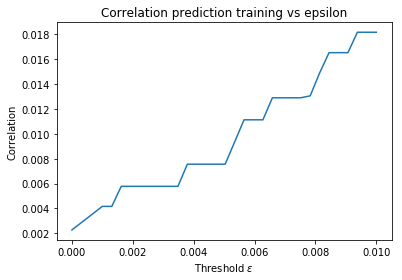

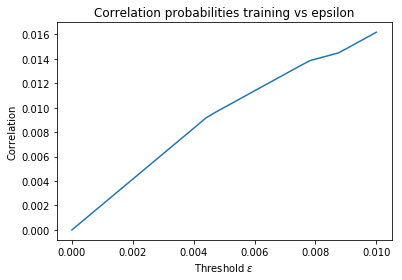

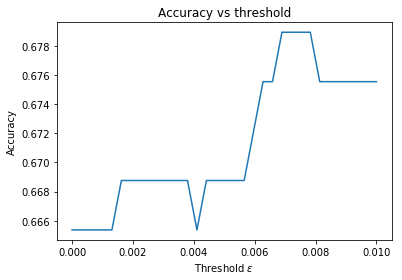

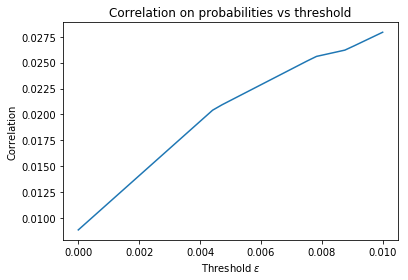

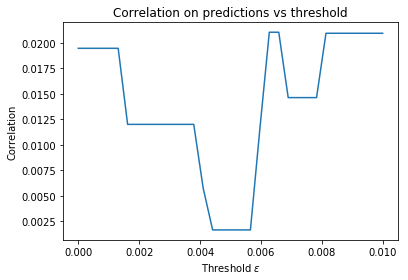

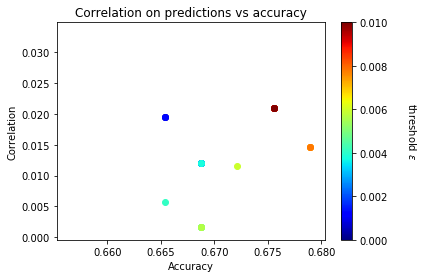

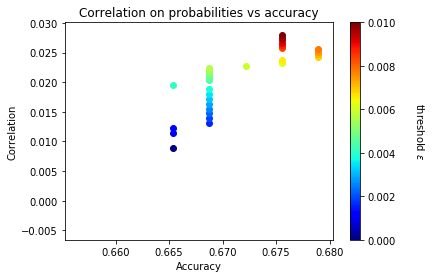

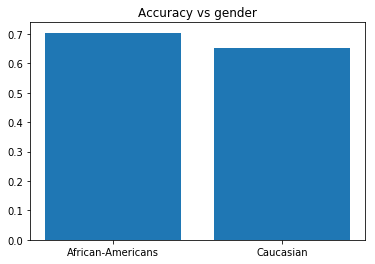

In [17]:
# Fairness 
tmpdir=gdir 
gdir = gdir + "/scaled" 
thresholds = np.concatenate((np.array([0]),np.linspace(0.001,0.01,num=30)))
accuracy_fair = [0]*len(thresholds)
correlation_proba_fair= [0]*len(thresholds)
correlation_pred_fair = [0]*len(thresholds)
accuracy_fair_male = [0]*len(thresholds)
accuracy_fair_female = [0]*len(thresholds)
training_pred_corr = [0]*len(thresholds)
training_proba_corr = [0]*len(thresholds)

for i in range(len(thresholds)):
    e = thresholds[i]
    clf = MaxEntropy(fairness=True,epsilon=e)
    acc = []
    acc_male = []
    acc_female = []
    corr_proba= []
    corr_pred= [] 
    corr_pred_train = []
    corr_proba_train = []
    for train_index,test_index in kf.split(X_train_scaled): 
        z = X_train[:,-1]
        clf.fit(X_train_scaled[train_index],y_train[train_index])
        y_pred = clf.predict(X_train_scaled[test_index])
        y_true = y_train[test_index]
        acc += [accuracy_score(y_true,y_pred)]
        idx_female = np.where(z[test_index]==0)[0]
        idx_male = np.where(z[test_index]==1)[0]
        acc_female += [accuracy_score(y_pred[idx_female],y_true[idx_female])]
        acc_male += [accuracy_score(y_pred[idx_male],y_true[idx_male])]
        corr_proba+=[clf.get_proba_correlation()]
        corr_pred+= [clf.get_pred_correlation()]
        corr_pred_train += [clf.get_training_pred_correlation()]
        corr_proba_train += [clf.get_training_proba_correlation()]
    accuracy_fair[i] = np.mean(acc)
    accuracy_fair_male[i] = np.mean(acc_male)
    accuracy_fair_female[i] = np.mean(acc_female)
    correlation_pred_fair[i] = abs(np.mean(corr_pred))
    correlation_proba_fair[i]= abs(np.mean(corr_proba))
    training_pred_corr[i] = abs(np.mean(corr_pred_train))
    training_proba_corr[i]= abs(np.mean(corr_proba_train))
    
idx_best_acc = np.argmax(accuracy_fair)
idx_best_corr= np.argmin(correlation_pred_fair)
df_fair_scaled=pd.DataFrame(columns=['Accuracy','Correlation prediction','Correlation probability'])
df_fair_scaled.loc['best acc','Accuracy'] = accuracy_fair[idx_best_acc]
df_fair_scaled.loc['best acc','Correlation prediction'] = correlation_pred_fair[idx_best_acc]
df_fair_scaled.loc['best acc','Correlation probability'] = correlation_proba_fair[idx_best_acc]

df_fair_scaled.loc['best corr','Accuracy'] = accuracy_fair[idx_best_corr]
df_fair_scaled.loc['best corr','Correlation prediction'] = correlation_pred_fair[idx_best_corr]
df_fair_scaled.loc['best corr','Correlation probability'] = correlation_proba_fair[idx_best_corr]
    
plt.figure()
plt.title('Correlation prediction training vs epsilon')
plt.plot(thresholds,training_pred_corr)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')

plt.figure()
plt.title('Correlation probabilities training vs epsilon')
plt.plot(thresholds,training_proba_corr)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')

plt.figure()
plt.title("Accuracy vs threshold")
plt.plot(thresholds,accuracy_fair)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Accuracy')
plt.savefig(gdir + "acc_seuil_fair.png")

plt.figure()
plt.title("Correlation on probabilities vs threshold")
plt.plot(thresholds,correlation_proba_fair)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir +'corr_proba_seuil_fair.png')

plt.figure()
plt.title("Correlation on predictions vs threshold")
plt.plot(thresholds,correlation_pred_fair)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir +'corr_pred_seuil_fair.png')


normalize = mcolors.Normalize(vmin=thresholds.min(), vmax=thresholds.max())
colormap = cm.jet
plt.figure()
plt.title("Correlation on predictions vs accuracy")
for i in range(len(accuracy_fair)):
    plt.scatter(accuracy_fair[i],correlation_pred_fair[i],color=colormap(normalize(thresholds[i])))
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(thresholds)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'threshold $\epsilon$', rotation=270, labelpad=30)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_pred_acc_fair.png')

plt.figure()
plt.title("Correlation on probabilities vs accuracy")
for i in range(len(accuracy_fair)):
    plt.scatter(accuracy_fair[i],correlation_proba_fair[i],color=colormap(normalize(thresholds[i])))
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(thresholds)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'threshold $\epsilon$', rotation=270, labelpad=30)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_acc_fair.png')



plt.figure() 
plt.title("Accuracy vs gender")
plt.bar(['African-Americans', 'Caucasian'],[np.mean(accuracy_fair_male),np.mean(accuracy_fair_female)])
plt.savefig(gdir+'acc_gender_fair.png')
plt.show()

gdir = tmpdir


Data are not scaled

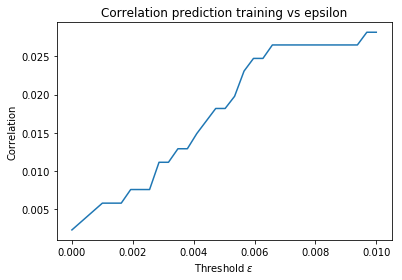

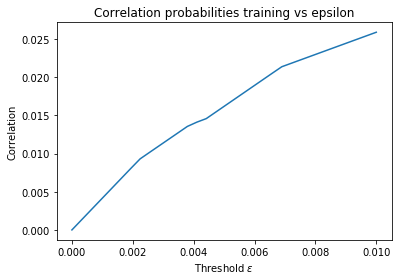

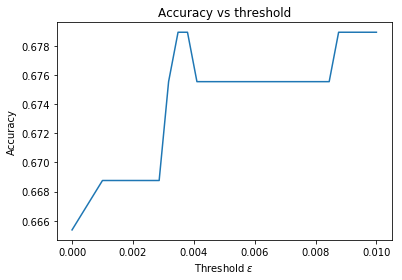

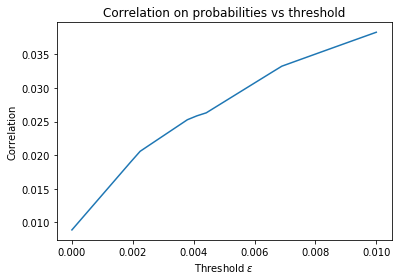

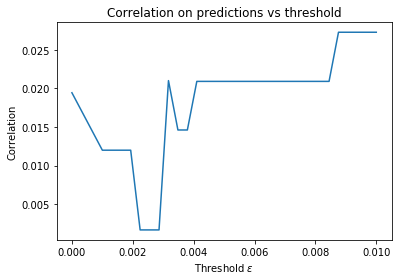

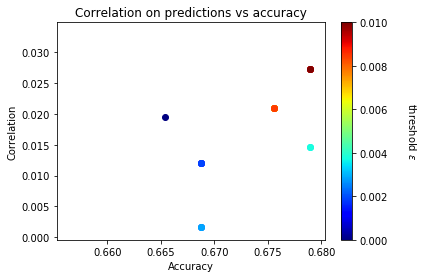

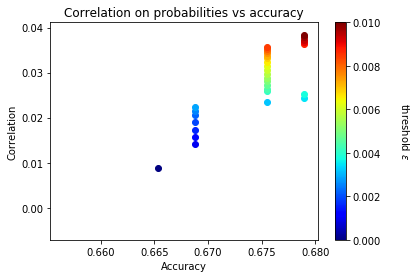

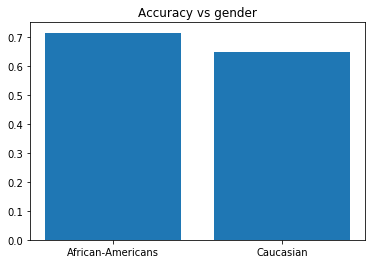

In [18]:
# Fairness 
thresholds = np.concatenate((np.array([0]),np.linspace(0.001,0.01,num=30)))
accuracy_fair = [0]*len(thresholds)
correlation_proba_fair= [0]*len(thresholds)
correlation_pred_fair = [0]*len(thresholds)
accuracy_fair_male = [0]*len(thresholds)
accuracy_fair_female = [0]*len(thresholds)
training_pred_corr = [0]*len(thresholds)
training_proba_corr = [0]*len(thresholds)

for i in range(len(thresholds)):
    e = thresholds[i]
    clf = MaxEntropy(fairness=True,epsilon=e)
    acc = []
    acc_male = []
    acc_female = []
    corr_proba= []
    corr_pred= [] 
    corr_pred_train = []
    corr_proba_train = []
    for train_index,test_index in kf.split(X_train): 
        z = X_train[:,-1]
        clf.fit(X_train[train_index],y_train[train_index])
        y_pred = clf.predict(X_train[test_index])
        y_true = y_train[test_index]
        acc += [accuracy_score(y_true,y_pred)]
        idx_female = np.where(z[test_index]==0)[0]
        idx_male = np.where(z[test_index]==1)[0]
        acc_female += [accuracy_score(y_pred[idx_female],y_true[idx_female])]
        acc_male += [accuracy_score(y_pred[idx_male],y_true[idx_male])]
        corr_proba+=[clf.get_proba_correlation()]
        corr_pred+= [clf.get_pred_correlation()]
        corr_pred_train += [clf.get_training_pred_correlation()]
        corr_proba_train += [clf.get_training_proba_correlation()]
    accuracy_fair[i] = np.mean(acc)
    accuracy_fair_male[i] = np.mean(acc_male)
    accuracy_fair_female[i] = np.mean(acc_female)
    correlation_pred_fair[i] = abs(np.mean(corr_pred))
    correlation_proba_fair[i]= abs(np.mean(corr_proba))
    training_pred_corr[i] = abs(np.mean(corr_pred_train))
    training_proba_corr[i]= abs(np.mean(corr_proba_train))
    
idx_best_acc = np.argmax(accuracy_fair)
idx_best_corr= np.argmin(correlation_pred_fair)
df_fair_not_scaled=pd.DataFrame(columns=['Accuracy','Correlation prediction','Correlation probability'])
df_fair_not_scaled.loc['best acc','Accuracy'] = accuracy_fair[idx_best_acc]
df_fair_not_scaled.loc['best acc','Correlation prediction'] = correlation_pred_fair[idx_best_acc]
df_fair_not_scaled.loc['best acc','Correlation probability'] = correlation_proba_fair[idx_best_acc]

df_fair_not_scaled.loc['best corr','Accuracy'] = accuracy_fair[idx_best_corr]
df_fair_not_scaled.loc['best corr','Correlation prediction'] = correlation_pred_fair[idx_best_corr]
df_fair_not_scaled.loc['best corr','Correlation probability'] = correlation_proba_fair[idx_best_corr]

plt.figure()
plt.title('Correlation prediction training vs epsilon')
plt.plot(thresholds,training_pred_corr)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')

plt.figure()
plt.title('Correlation probabilities training vs epsilon')
plt.plot(thresholds,training_proba_corr)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')

plt.figure()
plt.title("Accuracy vs threshold")
plt.plot(thresholds,accuracy_fair)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Accuracy')
plt.savefig(gdir + "acc_seuil_fair.png")

plt.figure()
plt.title("Correlation on probabilities vs threshold")
plt.plot(thresholds,correlation_proba_fair)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir +'corr_proba_seuil_fair.png')

plt.figure()
plt.title("Correlation on predictions vs threshold")
plt.plot(thresholds,correlation_pred_fair)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir +'corr_pred_seuil_fair.png')


normalize = mcolors.Normalize(vmin=thresholds.min(), vmax=thresholds.max())
colormap = cm.jet
plt.figure()
plt.title("Correlation on predictions vs accuracy")
for i in range(len(accuracy_fair)):
    plt.scatter(accuracy_fair[i],correlation_pred_fair[i],color=colormap(normalize(thresholds[i])))
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(thresholds)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'threshold $\epsilon$', rotation=270, labelpad=30)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_pred_acc_fair.png')

plt.figure()
plt.title("Correlation on probabilities vs accuracy")
for i in range(len(accuracy_fair)):
    plt.scatter(accuracy_fair[i],correlation_proba_fair[i],color=colormap(normalize(thresholds[i])))
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(thresholds)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'threshold $\epsilon$', rotation=270, labelpad=30)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_acc_fair.png')



plt.figure() 
plt.title("Accuracy vs gender")
plt.bar(['Male', 'Female'],[np.mean(accuracy_fair_male),np.mean(accuracy_fair_female)])
plt.savefig(gdir+'acc_gender_fair.png')
plt.show()




Summary of the result for the <b>model with the threshold constraint</b>. This shows the best result in terms of accuracy and the best result in terms of correlation with the binary predictions

In [19]:
print("\nModel with threshold constraints\n")

print("\nData are scaled\n")
display(df_fair_scaled)

print("\nData are not scaled\n")
display(df_fair_not_scaled)


Model with threshold constraints


Data are scaled



,Accuracy,Correlation prediction,Correlation probability
best acc,0.678927,0.0146187,0.0242162
best corr,0.668757,0.00165974,0.0204111



Data are not scaled



,Accuracy,Correlation prediction,Correlation probability
best acc,0.678927,0.0146187,0.0243366
best corr,0.668757,0.00165974,0.020574


## Results for both  post-processing approaches

#### first approach
First approach consists in fitting the simple MaxEnt model and then making predictions on both the training set and the test set. In a second step, a least square optimization program is ran over all the predictions that we made with a constraint on the covariance with the sensible attribute 

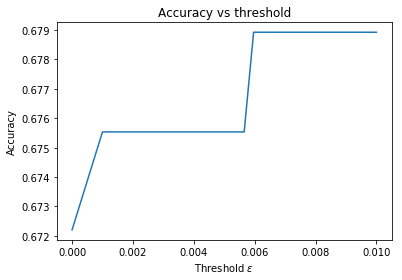

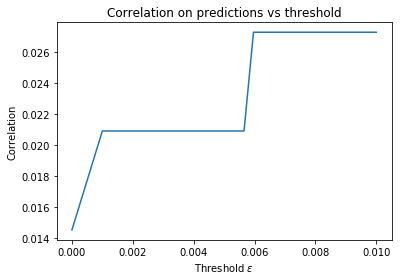

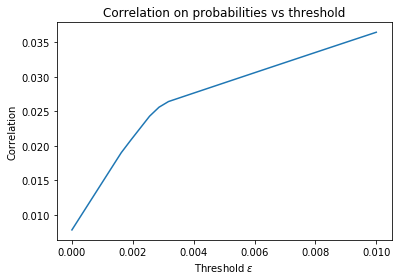

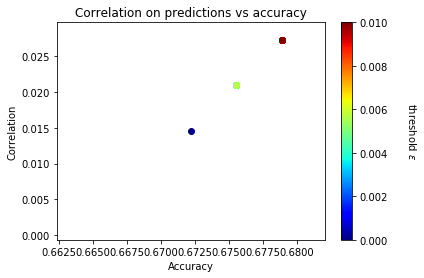

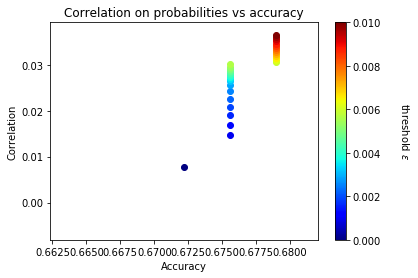

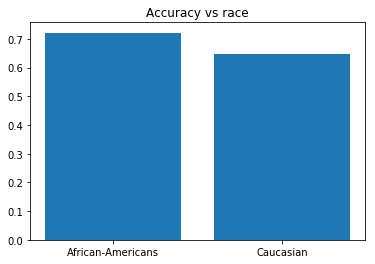

In [20]:
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
#thresholds = np.linspace(0.001,0.01,num=30)
thresholds = np.concatenate((np.array([0]),np.linspace(0.001,0.01,num=30)))
accuracy_post = [0]*len(thresholds)
accuracy_post_caucasian = [0]*len(thresholds)
accuracy_post_afro = [0]*len(thresholds)
correlation_pred_post= [0]*len(thresholds)
correlation_proba_post=[0]*len(thresholds)

for i in range(len(thresholds)):
    e = thresholds[i]
    corr_proba = []
    corr_pred = []
    acc = []
    acc_caucasian = []
    acc_afro = []
    #corr_pred_train = []
    #corr_proba_train = []
    for train_index, test_index in kf.split(X_train):
        clf.fit(X_train[train_index],y_train[train_index])
        y_proba = clf.predict_proba(X_train)
        n = y_proba.shape[0]
        yls = cp.Variable(shape=n)
        obj = cp.Minimize(cp.sum_squares(yls-y_proba))
        H = np.eye(n)-1/n*np.ones(n)
        z = X_train[:,-1]
        constraints = [yls >= 0, 
                       1/(n-1)*(z.T@H@yls) <= e,
                       1/(n-1)*(z.T@H@yls) >= -e]
        prob=cp.Problem(obj,constraints)
        prob.solve(solver=cp.MOSEK, verbose= False)
        y_proba = yls.value[test_index]
        y_pred = np.where(y_proba>0.5,1,0)
        y_true = y_train[test_index]
        acc += [accuracy_score(y_true,y_pred)]
        idx_caucasian = np.where(z[test_index]==0)[0]
        idx_afro = np.where(z[test_index]==1)[0]
        acc_caucasian += [accuracy_score(y_pred[idx_caucasian],y_true[idx_caucasian])]
        acc_afro += [accuracy_score(y_pred[idx_afro],y_true[idx_afro])]
        corr_pred+= [np.corrcoef(z[test_index]-np.mean(z[test_index]),y_pred)[0,1]]
        corr_proba+=[np.corrcoef(z[test_index]-np.mean(z[test_index]),y_proba)[0,1]]
        
    accuracy_post[i] = np.mean(acc)
    correlation_pred_post[i] = abs(np.mean(corr_pred))
    correlation_proba_post[i]=abs(np.mean(corr_proba))
    accuracy_post_afro[i] = np.mean(acc_afro)
    accuracy_post_caucasian[i] = np.mean(acc_caucasian)
    
plt.figure()
plt.title("Accuracy vs threshold")
plt.plot(thresholds,accuracy_post)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Accuracy')
plt.savefig(gdir+'acc_seuil_post.png')

plt.figure()
plt.title("Correlation on predictions vs threshold")
plt.plot(thresholds,correlation_pred_post)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_pred_seuil_post.png')

plt.figure()
plt.title("Correlation on probabilities vs threshold")
plt.plot(thresholds,correlation_proba_post)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_seuil_post.png')



normalize = mcolors.Normalize(vmin=thresholds.min(), vmax=thresholds.max())
colormap = cm.jet
plt.figure()
plt.title("Correlation on predictions vs accuracy")
for i in range(len(accuracy_post)):
    plt.scatter(accuracy_post[i],correlation_pred_post[i],color=colormap(normalize(thresholds[i])))
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(thresholds)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'threshold $\epsilon$', rotation=270, labelpad=30)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_acc_post.png')


plt.figure()
plt.title("Correlation on probabilities vs accuracy")
for i in range(len(accuracy_post)):
    plt.scatter(accuracy_post[i],correlation_proba_post[i],color=colormap(normalize(thresholds[i])))
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(thresholds)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'threshold $\epsilon$', rotation=270, labelpad=30)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir +'corr_pred_acc_post.png')


plt.figure() 
plt.title("Accuracy vs gender")
plt.bar(['Male', 'Female'],[np.mean(accuracy_post_afro),np.mean(accuracy_post_caucasian)])
plt.savefig(gdir+'acc_race_post.png')
plt.show()


Summary of the best results obtained with <b>post-processing first approach</b>. It shows the best accuracy and the best correlation with the binary predictions that were obtained when varying the threshold $\epsilon$.

In [21]:
idx_best_acc = np.argmax(accuracy_post)
idx_best_corr= np.argmin(correlation_pred_post)
df=pd.DataFrame(columns=['Accuracy','Correlation prediction','Correlation probability'])
df.loc['best acc','Accuracy'] = accuracy_post[idx_best_acc]
df.loc['best acc','Correlation prediction'] = correlation_pred_post[idx_best_acc]
df.loc['best acc','Correlation probability'] = correlation_proba_post[idx_best_acc]

df.loc['best corr','Accuracy'] = accuracy_post[idx_best_corr]
df.loc['best corr','Correlation prediction'] = correlation_pred_post[idx_best_corr]
df.loc['best corr','Correlation probability'] = correlation_proba_post[idx_best_corr]
print("\nPre-processing 1rst approach\n")
display(df)



Pre-processing 1rst approach



,Accuracy,Correlation prediction,Correlation probability
best acc,0.678927,0.0272934,0.030563
best corr,0.672203,0.0145367,0.0078185


#### second approach
The second approach consists in fitting the simple MaxEnt model and then making predictions on the test set uniquely. In a second step, a least square optimization is ran with covariance constraint on the predictions. 

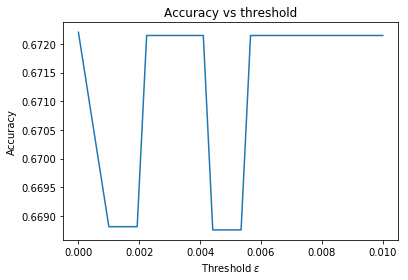

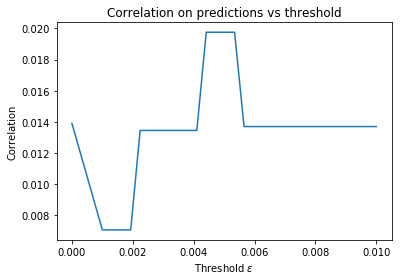

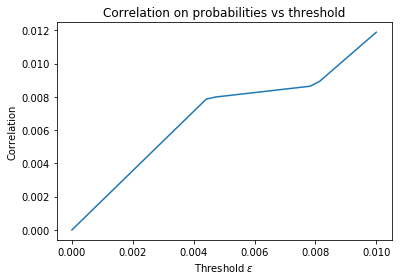

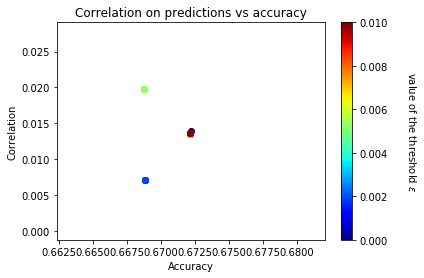

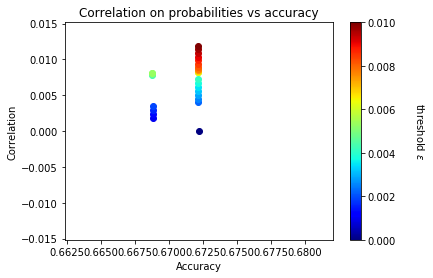

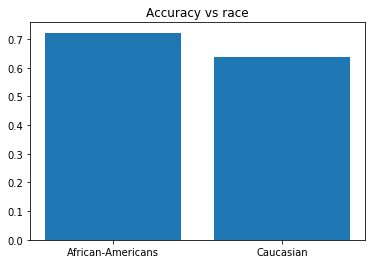

In [22]:
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
thresholds = np.concatenate((np.array([0]),np.linspace(0.001,0.01,num=30)))
accuracy_post2 = [0]*len(thresholds)
accuracy_post2_caucasian = [0]*len(thresholds)
accuracy_post2_afro = [0]*len(thresholds)
correlation_pred_post2= [0]*len(thresholds)
correlation_proba_post2=[0]*len(thresholds)

for i in range(len(thresholds)):
    e = thresholds[i]
    corr_proba = []
    corr_pred = []
    acc = []
    acc_caucasian = []
    acc_afro = []
    #corr_pred_train = []
    #corr_proba_train = []
    for train_index, test_index in kf.split(X_train):
        clf.fit(X_train[train_index],y_train[train_index])
        y_proba = clf.predict_proba(X_train[test_index])
        n = y_proba.shape[0]
        yls = cp.Variable(shape=n)
        obj = cp.Minimize(cp.sum_squares(yls-y_proba))
        H = np.eye(n)-1/n*np.ones(n)
        z = X_train[test_index,-1]
        constraints = [yls >= 0, 
                       1/(n-1)*(z.T@H@yls) <= e,
                       1/(n-1)*(z.T@H@yls) >= -e]
        prob=cp.Problem(obj,constraints)
        prob.solve(solver=cp.MOSEK, verbose= False)
        y_proba = yls.value
        y_pred = np.where(y_proba>0.5,1,0)
        y_true = y_train[test_index]
        acc += [accuracy_score(y_true,y_pred)]
        idx_caucasian = np.where(z==0)[0]
        idx_afro = np.where(z==1)[0]
        acc_caucasian += [accuracy_score(y_pred[idx_caucasian],y_true[idx_caucasian])]
        acc_afro += [accuracy_score(y_pred[idx_afro],y_true[idx_afro])]
        corr_pred+= [np.corrcoef(z-np.mean(z),y_pred)[0,1]]
        corr_proba+=[np.corrcoef(z-np.mean(z),y_proba)[0,1]]

    accuracy_post2[i] = np.mean(acc)
    correlation_pred_post2[i] = abs(np.mean(corr_pred))
    correlation_proba_post2[i]=abs(np.mean(corr_proba))
    accuracy_post2_afro[i] = np.mean(acc_afro)
    accuracy_post2_caucasian[i] = np.mean(acc_caucasian)


plt.figure()
plt.title("Accuracy vs threshold")
plt.plot(thresholds,accuracy_post2)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Accuracy')
plt.savefig(gdir+'acc_seuil_post2.png')

plt.figure()
plt.title("Correlation on predictions vs threshold")
plt.plot(thresholds,correlation_pred_post2)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_pred_seuil_post2.png')

plt.figure()
plt.title("Correlation on probabilities vs threshold")
plt.plot(thresholds,correlation_proba_post2)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_seuil_post2.png')



normalize = mcolors.Normalize(vmin=thresholds.min(), vmax=thresholds.max())
colormap = cm.jet
plt.figure()
plt.title("Correlation on predictions vs accuracy")
for i in range(len(accuracy_post2)):
    plt.scatter(accuracy_post2[i],correlation_pred_post2[i],color=colormap(normalize(thresholds[i])))
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(thresholds)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'value of the threshold $\epsilon$', rotation=270,labelpad=30)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_acc_post2.png')


plt.figure()
plt.title("Correlation on probabilities vs accuracy")
for i in range(len(accuracy_post2)):
    plt.scatter(accuracy_post2[i],correlation_proba_post2[i],color=colormap(normalize(thresholds[i])))
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(thresholds)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'threshold $\epsilon$', rotation=270,labelpad=30)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_pred_acc_post2.png')



plt.figure() 
plt.title("Accuracy vs gender")
plt.bar(['Male', 'Female'],[np.mean(accuracy_post2_afro),np.mean(accuracy_post2_caucasian)])
plt.savefig(gdir+'acc_race_post2.png')
plt.show()


Summary of the best results obtained with <b>post-processing second approach</b>. It shows the best accuracy and the best correlation with the binary predictions that were obtained when varying the threshold $\epsilon$.

In [23]:
idx_best_acc = np.argmax(accuracy_post2)
idx_best_corr= np.argmin(correlation_pred_post2)
df=pd.DataFrame(columns=['Accuracy','Correlation prediction','Correlation probability'])
df.loc['best acc','Accuracy'] = accuracy_post2[idx_best_acc]
df.loc['best acc','Correlation prediction'] = correlation_pred_post2[idx_best_acc]
df.loc['best acc','Correlation probability'] = correlation_proba_post2[idx_best_acc]

df.loc['best corr','Accuracy'] = accuracy_post2[idx_best_corr]
df.loc['best corr','Correlation prediction'] = correlation_pred_post2[idx_best_corr]
df.loc['best corr','Correlation probability'] = correlation_proba_post2[idx_best_corr]

print("\nPost-processing 2nd approach\n")
display(df)



Post-processing 2nd approach



,Accuracy,Correlation prediction,Correlation probability
best acc,0.672203,0.0139068,7.7138e-11
best corr,0.668814,0.00706414,0.00178173


## Combining pre-processing with post-processing

Preprocessing and post-processing first approach

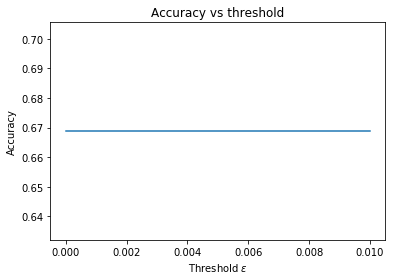

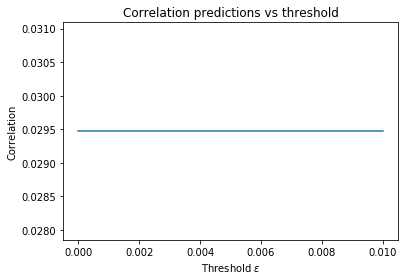

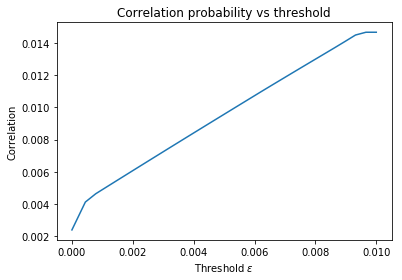

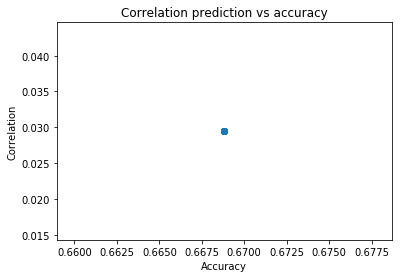

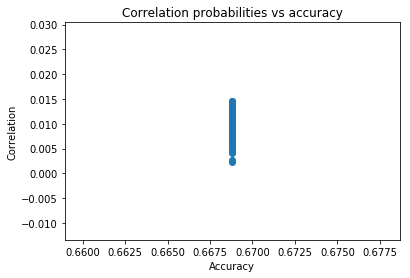

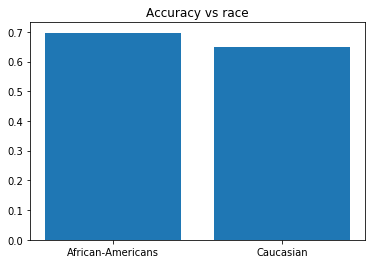

In [24]:
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
thresholds = np.concatenate((np.array([0]),np.linspace(0.0001,0.01,num=30)))
accuracy_post_proj = [0]*len(thresholds)
accuracy_post_caucasian_proj = [0]*len(thresholds)
accuracy_post_afro_proj = [0]*len(thresholds) 
correlation_pred_post_proj = [0]*len(thresholds)
correlation_proba_post_proj= [0]*len(thresholds)
X_proj_train = projection(X_train)
y_proj_train = y_train
for i in range(len(thresholds)):
    e = thresholds[i]
    corr_pred = []
    corr_proba= []
    acc = []
    acc_afro = []
    acc_caucasian = [] 
    for train_index, test_index in kf.split(X_proj_train):
        z = X_proj_train[:,-1]
        clf.fit(X_proj_train[train_index],y_proj_train[train_index])
        y_proba = clf.predict_proba(X_proj_train)
        n = y_proba.shape[0]
        yls = cp.Variable(shape=n)
        obj = cp.Minimize(cp.sum_squares(yls-y_proba))
        H = np.eye(n)-1/n*np.ones(n)
        z = X_proj_train[:,-1]
        constraints = [yls >= 0, 
                       1/(n-1)*(z.T@H@yls) <= e,
                       1/(n-1)*(z.T@H@yls) >= -e]
        prob=cp.Problem(obj,constraints)
        prob.solve(solver=cp.MOSEK, verbose= False)
        idx_caucasian = np.where(z[test_index]==0)[0]
        y_pred = np.where(yls.value[test_index]>0.5,1,0)
        y_proba=yls.value[test_index]
        y_true = y_proj_train[test_index]
        idx_afro = np.where(z[test_index]==1)[0]
        idx_caucasian=np.where(z[test_index]==0)[0]
        acc_caucasian += [accuracy_score(y_pred[idx_caucasian],y_true[idx_caucasian])]
        acc_afro += [accuracy_score(y_pred[idx_afro],y_true[idx_afro])]
        acc += [accuracy_score(y_true,y_pred)]
        corr_pred+= [np.corrcoef(z[test_index]-np.mean(z[test_index]),y_pred)[0,1]]
        corr_proba+= [np.corrcoef(z[test_index]-np.mean(z[test_index]),y_proba)[0,1]]
        
    accuracy_post_proj[i] = np.mean(acc)
    correlation_pred_post_proj[i] = abs(np.mean(corr_pred))
    correlation_proba_post_proj[i]= abs(np.mean(corr_proba))
    accuracy_post_afro_proj[i] = np.mean(acc_afro)
    accuracy_post_caucasian_proj[i] = np.mean(acc_caucasian)

    
plt.figure()
plt.title("Accuracy vs threshold")
plt.plot(thresholds,accuracy_post_proj)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Accuracy')
plt.savefig(gdir+'acc_seuil_post_proj.png')


plt.figure()
plt.title("Correlation predictions vs threshold")
plt.plot(thresholds,correlation_pred_post_proj)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_pred_seuil_post_proj.png')

plt.figure()
plt.title("Correlation probability vs threshold")
plt.plot(thresholds,correlation_proba_post_proj)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_seuil_post_proj.png')

plt.figure()
plt.title("Correlation prediction vs accuracy")
plt.scatter(accuracy_post_proj,correlation_pred_post_proj)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_pred_acc_post_proj.png')


plt.figure()
plt.title("Correlation probabilities vs accuracy")
plt.scatter(accuracy_post_proj,correlation_proba_post_proj)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_acc_post_proj.png')

plt.figure() 
plt.title("Accuracy vs gender")
plt.bar(['Male', 'Female'],[np.mean(accuracy_post_afro_proj),np.mean(accuracy_post_caucasian_proj)])
plt.savefig(gdir+'acc_race_post_proj.png')
plt.show()

Pre-processing and post-processing second approach

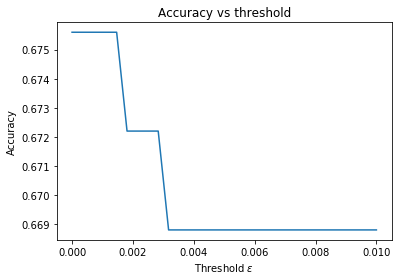

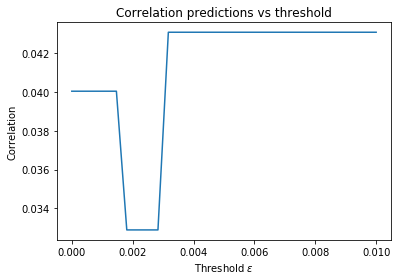

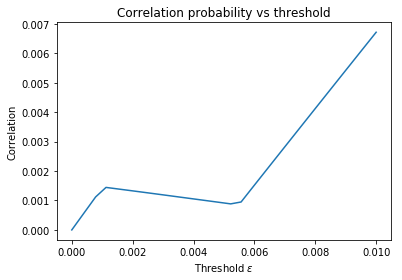

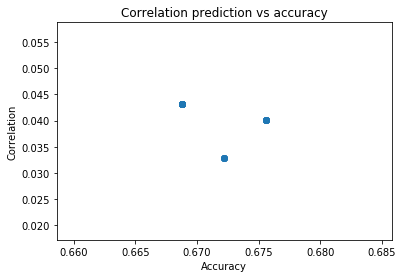

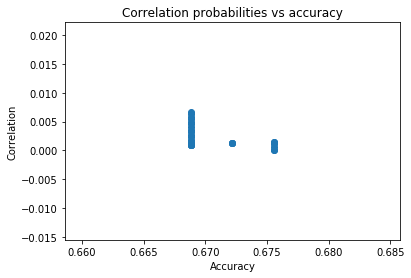

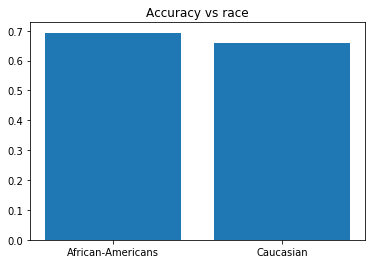

In [26]:
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
thresholds = np.concatenate((np.array([0]),np.linspace(0.0001,0.01,num=30)))
accuracy_post2_proj = [0]*len(thresholds)
accuracy_post2_caucasian_proj = [0]*len(thresholds)
accuracy_post2_afro_proj = [0]*len(thresholds)
correlation_pred_post2_proj= [0]*len(thresholds)
correlation_proba_post2_proj=[0]*len(thresholds)
X_train_proj = projection(X_train)

for i in range(len(thresholds)):
    e = thresholds[i]
    corr_proba = []
    corr_pred = []
    acc = []
    acc_caucasian = []
    acc_afro = []
    for train_index, test_index in kf.split(X_train):
        clf.fit(X_train_proj[train_index],y_train[train_index])
        y_proba = clf.predict_proba(X_train_proj[test_index])
        n = y_proba.shape[0]
        yls = cp.Variable(shape=n)
        obj = cp.Minimize(cp.sum_squares(yls-y_proba))
        H = np.eye(n)-1/n*np.ones(n)
        z = X_train_proj[test_index,-1]
        constraints = [yls >= 0, 
                       1/(n-1)*(z.T@H@yls) <= e,
                       1/(n-1)*(z.T@H@yls) >= -e]
        prob=cp.Problem(obj,constraints)
        prob.solve(solver=cp.MOSEK, verbose= False)
        y_proba = yls.value
        y_pred = np.where(y_proba>0.5,1,0)
        y_true = y_train[test_index]
        idx_afro = np.where(z==1)[0]
        idx_caucasian = np.where(z==0)[0]
        acc_caucasian += [accuracy_score(y_pred[idx_caucasian],y_true[idx_caucasian])]
        acc_afro += [accuracy_score(y_pred[idx_afro],y_true[idx_afro])]
        acc += [accuracy_score(y_true,y_pred)]
        corr_pred+= [np.corrcoef(z-np.mean(z),y_pred)[0,1]]
        corr_proba+= [np.corrcoef(z-np.mean(z),y_proba)[0,1]]
        
    accuracy_post2_proj[i] = np.mean(acc)
    correlation_pred_post2_proj[i] = abs(np.mean(corr_pred))
    correlation_proba_post2_proj[i]= abs(np.mean(corr_proba))
    accuracy_post2_afro_proj[i] = np.mean(acc_afro)
    accuracy_post2_caucasian_proj[i] = np.mean(acc_caucasian)

    
plt.figure()
plt.title("Accuracy vs threshold")
plt.plot(thresholds,accuracy_post2_proj)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Accuracy')
plt.savefig(gdir+'acc_seuil_post2_proj.png')


plt.figure()
plt.title("Correlation predictions vs threshold")
plt.plot(thresholds,correlation_pred_post2_proj)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_pred_seuil_post2_proj.png')

plt.figure()
plt.title("Correlation probability vs threshold")
plt.plot(thresholds,correlation_proba_post2_proj)
plt.xlabel(r'Threshold $\epsilon$')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_seuil_post2_proj.png')

plt.figure()
plt.title("Correlation prediction vs accuracy")
plt.scatter(accuracy_post2_proj,correlation_pred_post2_proj)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_pred_acc_post2_proj.png')


plt.figure()
plt.title("Correlation probabilities vs accuracy")
plt.scatter(accuracy_post2_proj,correlation_proba_post2_proj)
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.savefig(gdir+'corr_proba_acc_post2_proj.png')

plt.figure() 
plt.title("Accuracy vs gender")
plt.bar(['Male', 'Female'],[np.mean(accuracy_post2_afro_proj),np.mean(accuracy_post2_caucasian_proj)])
plt.savefig(gdir+'acc_race_post2_proj.png')
plt.show()

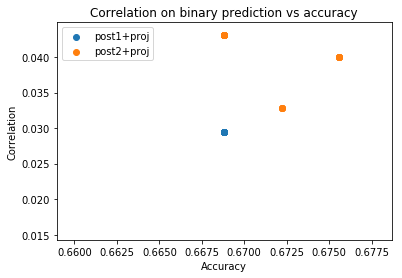

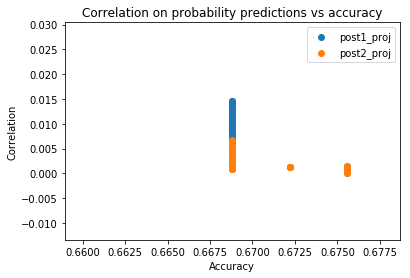

In [54]:
plt.figure()
plt.title("Correlation on binary prediction vs accuracy")
plt.scatter(accuracy_post_proj,correlation_pred_post_proj,label='post1+proj')
plt.scatter(accuracy_post2_proj,correlation_pred_post2_proj,label='post2+proj')
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.legend()
plt.savefig(gdir+'pred_post_proj_comp')
plt.show()

plt.figure()
plt.title("Correlation on probability predictions vs accuracy")
plt.scatter(accuracy_post_proj,correlation_proba_post_proj,label='post1_proj')
plt.scatter(accuracy_post2_proj,correlation_proba_post2_proj,label='post2_proj')
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
plt.legend()
plt.savefig(gdir+'proba_post_proj_comp')
plt.show()

### Comparing all methods together

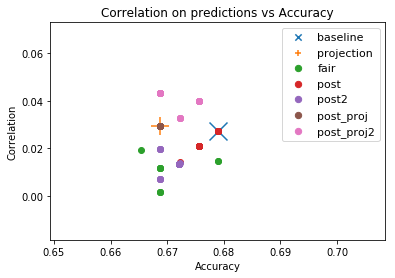

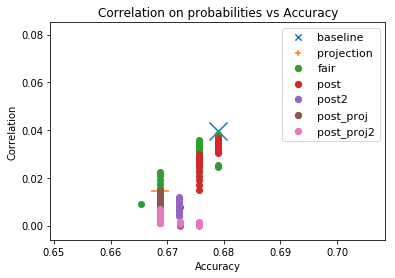

In [59]:
plt.figure()
plt.title("Correlation on predictions vs Accuracy")
plt.scatter(np.mean(acc_baseline),abs(np.mean(corr_pred_baseline)),label='baseline',marker='x',s=(3*plt.rcParams['lines.markersize'])** 2.)
plt.scatter(np.mean(acc_proj),abs(np.mean(corr_pred_proj)),label='projection',marker='+',s=(3*plt.rcParams['lines.markersize'])** 2.)
plt.scatter(accuracy_fair,correlation_pred_fair,label='fair')
plt.scatter(accuracy_post,correlation_pred_post,label='post')
plt.scatter(accuracy_post2,correlation_pred_post2,label='post2')
plt.scatter(accuracy_post_proj,correlation_pred_post_proj,label='post_proj')
plt.scatter(accuracy_post2_proj,correlation_pred_post2_proj,label='post_proj2')
plt.xlabel('Accuracy')
plt.ylabel('Correlation')
lgnd = plt.legend(scatterpoints=1, fontsize=11)
for handle in lgnd.legendHandles:
    handle.set_sizes([40])
plt.savefig(gdir+'corr_pred_acc_all.png')
plt.show()

plt.figure()
plt.title("Correlation on probabilities vs Accuracy")
plt.scatter(np.mean(acc_baseline),abs(np.mean(corr_proba_baseline)),label='baseline',marker='x',s=(3*plt.rcParams['lines.markersize'])** 2.)
plt.scatter(np.mean(acc_proj),abs(np.mean(corr_proba_proj)),label='projection',marker='+',s=(3*plt.rcParams['lines.markersize'])** 2.)
plt.scatter(accuracy_fair,correlation_proba_fair,label='fair')
plt.scatter(accuracy_post,correlation_proba_post,label='post')
plt.scatter(accuracy_post2,correlation_proba_post2,label='post2')
plt.scatter(accuracy_post_proj,correlation_proba_post_proj,label='post_proj')
plt.scatter(accuracy_post2_proj,correlation_proba_post2_proj,label='post_proj2')

plt.xlabel('Accuracy')
plt.ylabel('Correlation')
lgnd = plt.legend(scatterpoints=1, fontsize=11)
for handle in lgnd.legendHandles:
    handle.set_sizes([40])
#plt.legend()
plt.savefig(gdir+'corr_proba_acc_all.png')
plt.show()



### Comparison with a random forest classifier

MaxEnt is non-parametric and therefore does not offer the possibility to boost performance thanks to the choice of the metaparameter. Can RandomForest achieve better performances thanks to this? 

In [29]:
df_comp_rf_pre = pd.DataFrame(columns=['Accuracy','Correlation predictions','Correlation probabilities'])
df_comp_rf_post = pd.DataFrame(columns=['Accuracy','Correlation predictions','Correlation probabilities'])

In [30]:
# Preprocessing projection only
clf = MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
corr_pred_proj = []
corr_proba_proj = []
acc_proj = []
#X_proj_train = projection(X_train)
for train_index, test_index in kf.split(X_train):
    X_proj_train = projection(X_train[train_index])
    X_proj_test = projection(X_train[test_index])
    clf.fit(X_proj_train,y_proj_train[train_index])
    y_pred = clf.predict(X_proj_test)
    y_true = y_proj_train[test_index]
    acc_proj += [accuracy_score(y_true,y_pred)]
    corr_pred_proj += [clf.get_pred_correlation()]
    corr_proba_proj+= [clf.get_proba_correlation()]
#cv_results = cross_validate(clf, X_train, y_train, cv=5,return_estimator=True,scoring='accuracy')
print("projection accuracy : {} (+/- {})".format(np.mean(acc_proj),np.std(acc_proj)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_pred_proj),np.std(corr_pred_proj)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_proba_proj),np.std(corr_proba_proj)))

df_comp_rf_pre.loc['MaxEnt','Accuracy'] = np.mean(acc_proj)
df_comp_rf_pre.loc['MaxEnt','Correlation predictions'] = np.mean(corr_pred_proj)
df_comp_rf_pre.loc['MaxEnt','Correlation probabilities'] = np.mean(corr_proba_proj)

projection accuracy : 0.6788700564971751 (+/- 0.03185078043380405)
projection correlation on predictions : 0.08948441393028485 (+/- 0.04575467041480692)
projection correlation on predictions : 0.030815841632599383 (+/- 0.03596024211552089)


In [31]:
#POST ZERO CORRELATION
clf=MaxEntropy()
nfold = 5
kf = KFold(n_splits=nfold)
acc=[]
corr_pred=[]
corr_proba=[]
for train_index, test_index in kf.split(X_train):
        clf.fit(X_train[train_index],y_train[train_index])
        y_proba = clf.predict_proba(X_train)
        n = y_proba.shape[0]
        yls = cp.Variable(shape=n)
        obj = cp.Minimize(cp.sum_squares(yls-y_proba))
        H = np.eye(n)-1/n*np.ones(n)
        z = X_train[:,-1]
        constraints = [yls >= 0, 
                       1/(n-1)*(z.T@H@yls) <= 0.001,
                       1/(n-1)*(z.T@H@yls) >= -0.001]
        prob=cp.Problem(obj,constraints)
        prob.solve(solver=cp.MOSEK, verbose= False)
        y_proba = yls.value[test_index]
        y_pred = np.where(y_proba>0.5,1,0)
        y_true = y_train[test_index]
        acc += [accuracy_score(y_true,y_pred)]
        corr_pred += [correlation(z[test_index]-np.mean(z[test_index]),y_pred)[0,0]]
        corr_proba+= [correlation(z[test_index]-np.mean(z[test_index]),y_proba)[0,0]]
print("accuracy_post :{}".format(np.mean(acc)))
print("corr pred post:{}".format(np.mean(corr_pred)))
print("corr proba post:{}".format(np.mean(corr_proba)))

df_comp_rf_post.loc['MaxEnt','Accuracy'] = np.mean(acc)
df_comp_rf_post.loc['MaxEnt','Correlation predictions'] = np.mean(corr_pred)
df_comp_rf_post.loc['MaxEnt','Correlation probabilities'] = np.mean(corr_proba)


accuracy_post :0.6755367231638418
corr pred post:-0.0209212334824282
corr proba post:-0.014731568034709768


In [32]:
#Not tuned RF PRE
# Preprocessing projection only
rfc = RandomForestClassifier()
nfold = 5
kf = KFold(n_splits=nfold)
corr_pred = []
corr_proba = []
acc = []
#X_proj_train = projection(X_train)
for train_index, test_index in kf.split(X_train):
    z=X_train[:,-1]
    X_proj_train = projection(X_train[train_index])
    X_proj_test = projection(X_train[test_index])
    rfc.fit(X_proj_train[:,:-1],y_proj_train[train_index].ravel())
    y_pred = rfc.predict(X_proj_test[:,:-1])
    y_proba= rfc.predict_proba(X_proj_test[:,:-1])[:,1]
    y_true = y_proj_train[test_index]
    acc += [accuracy_score(y_true,y_pred)]
    corr_pred += [correlation(z[test_index]-np.mean(z[test_index]),y_pred)]
    corr_proba+= [correlation(z[test_index]-np.mean(z[test_index]),y_proba)]
#cv_results = cross_validate(clf, X_train, y_train, cv=5,return_estimator=True,scoring='accuracy')
print("projection accuracy : {} (+/- {})".format(np.mean(acc),np.std(acc)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_pred),np.std(corr_pred)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_proba),np.std(corr_proba)))

df_comp_rf_pre.loc['RF','Accuracy'] = np.mean(acc)
df_comp_rf_pre.loc['RF','Correlation predictions'] = np.mean(corr_pred)
df_comp_rf_pre.loc['RF','Correlation probabilities'] = np.mean(corr_proba)


projection accuracy : 0.6520338983050847 (+/- 0.04854563950754775)
projection correlation on predictions : 0.08578825335853277 (+/- 0.07439932585748865)
projection correlation on predictions : 0.06340283918705601 (+/- 0.038548254994986264)


In [33]:
#Not tuned RF ZERO DECORRELATION POST
rfc = RandomForestClassifier()
nfold = 5
kf = KFold(n_splits=nfold)

for train_index, test_index in kf.split(X_train):
    rfc.fit(X_train[train_index][:,:-1],y_train[train_index].ravel())
    y_proba = rfc.predict_proba(X_train[:,:-1])[:,1]
    n = y_proba.shape[0]
    yls = cp.Variable(shape=n)
    obj = cp.Minimize(cp.sum_squares(yls-y_proba))
    H = np.eye(n)-1/n*np.ones(n)
    z = X_train[:,-1]
    constraints = [yls >= 0, 
                   1/(n-1)*(z.T@H@yls) <= 0,
                   1/(n-1)*(z.T@H@yls) >= 0]
    prob=cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK, verbose= False)
    y_proba = yls.value[test_index]
    y_pred = np.where(y_proba>0.5,1,0)
    y_true = y_train[test_index]
    acc = accuracy_score(y_true,y_pred)
    corr_pred= correlation(z[test_index]-np.mean(z[test_index]),y_pred)[0,0]
    corr_proba=correlation(z[test_index]-np.mean(z[test_index]),y_proba)[0,0]

print("accuracy_rf :{}".format(acc))
print("corr pred rf:{}".format(corr_pred))
print("corr proba rf:{}".format(corr_proba))

df_comp_rf_post.loc['RF','Accuracy'] = np.mean(acc)
df_comp_rf_post.loc['RF','Correlation predictions'] = np.mean(corr_pred)
df_comp_rf_post.loc['RF','Correlation probabilities'] = np.mean(corr_proba)

accuracy_rf :0.6271186440677966
corr pred rf:-0.16783218203174288
corr proba rf:-0.052892336677498764


First, we use a Randomized Search to get a first grasp of what range of meta-parameters seems optimal for our problem. Then we use Grid Search and perform and exhaustive search of those intervals to try to find optimal performances.

In [34]:
#TUNING RF - RANDOMIZED SEARCH
from sklearn.model_selection import RandomizedSearchCV
rfc = RandomForestClassifier()
grid_params = {'n_estimators': range(1,25),
              'max_depth' : range(55,80),
                'min_samples_split': range(30,70),
               'min_samples_leaf': range(10,40),
              'bootstrap': [False,True]}
RFrs = RandomizedSearchCV(rfc,grid_params,cv=10,verbose=1,n_jobs=4,n_iter=1500)
RFrs_results = RFrs.fit(X_train,y_train.ravel())
print("Grid search results:")
print("best score found : ",RFrs_results.best_score_)
print("best parameters found: ",RFrs_results.best_params_)

Fitting 10 folds for each of 1500 candidates, totalling 15000 fits
Grid search results:
best score found :  0.6727586206896552
best parameters found:  {'n_estimators': 5, 'min_samples_split': 50, 'min_samples_leaf': 21, 'max_depth': 56, 'bootstrap': False}


In [44]:
#TUNING RF - GRID SEARCH 
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier()
grid_params = {'n_estimators': [2,3,4,5,6],
              'max_depth' : [54,55,56,57,58],
                'min_samples_split': [47,48,49,50,51,52,53],
               'min_samples_leaf': [19,20,21,22,23],
              'bootstrap': [False,True]}
RFgs = GridSearchCV(rfc, grid_params, cv = 10, verbose=1,n_jobs = 4)
RFgs_results = RFgs.fit(X_train,y_train.ravel())
print("Grid search results:")
print("best score found : ",RFgs_results.best_score_)
print("best parameters found: ",RFgs_results.best_params_)

Fitting 10 folds for each of 1750 candidates, totalling 17500 fits
Grid search results:
best score found :  0.6789655172413793
best parameters found:  {'bootstrap': False, 'max_depth': 56, 'min_samples_leaf': 21, 'min_samples_split': 47, 'n_estimators': 4}


#### Baseline results  

In [45]:

RFbp = RFgs_results.best_params_
rfc = RandomForestClassifier(n_estimators=RFbp['n_estimators'],max_depth=RFbp['max_depth'],
                             min_samples_split=RFbp['min_samples_split'],min_samples_leaf=RFbp['min_samples_leaf'],
                             bootstrap=RFbp['bootstrap'])
acc=[]
corr_pred = []
corr_proba = [] 
for train_index, test_index in kf.split(X_train):
    rfc.fit(X_train[train_index][:,:-1],y_train[train_index].ravel())
    y_pred = rfc.predict(X_train[test_index][:,:-1])
    y_proba= rfc.predict_proba(X_train[test_index][:,:-1])[:,1]
    y_true = y_train[test_index]
    acc += [accuracy_score(y_true,y_pred)]
    corr_pred += [np.corrcoef(X_train[test_index][:,-1]-np.mean(X_train[test_index][:,-1]),y_pred)[0,1]]
    corr_proba+= [np.corrcoef(X_train[test_index][:,-1]-np.mean(X_train[test_index][:,-1]),y_proba)[0,1]]
print("accuracy : {} (+/- {})".format(np.mean(acc),np.std(acc)))
print("correlation pred : {} (+/- {})".format(np.mean(corr_pred),np.std(corr_pred)))
print("correlation proba: {} (+/- {})".format(np.mean(corr_proba),np.std(corr_proba)))


accuracy : 0.597909604519774 (+/- 0.04256288848895656)
correlation pred : -0.0790713633097965 (+/- 0.12262003019050012)
correlation proba: -0.07279987042317448 (+/- 0.11341112280384917)


#### Pre-processing 

In [46]:
#tuned RF PRE
# Preprocessing projection only
rfc = RandomForestClassifier(n_estimators=RFbp['n_estimators'],max_depth=RFbp['max_depth'],
                             min_samples_split=RFbp['min_samples_split'],min_samples_leaf=RFbp['min_samples_leaf'],
                             bootstrap=RFbp['bootstrap'])
nfold = 5
kf = KFold(n_splits=nfold)
corr_pred = []
corr_proba = []
acc = []
#X_proj_train = projection(X_train)
for train_index, test_index in kf.split(X_train):
    X_proj_train = projection(X_train[train_index])
    X_proj_test = projection(X_train[test_index])
    z=X_train[:,-1]
    rfc.fit(X_proj_train[:,:-1],y_train[train_index].ravel())
    y_pred = rfc.predict(X_proj_test[:,:-1])
    y_proba= rfc.predict_proba(X_proj_test[:,:-1])[:,1]
    y_true = y_train[test_index]
    acc += [accuracy_score(y_true,y_pred)]
    corr_pred += [correlation(z[test_index]-np.mean(z[test_index]),y_pred)]
    corr_proba+= [correlation(z[test_index]-np.mean(z[test_index]),y_proba)]
print("projection accuracy : {} (+/- {})".format(np.mean(acc),np.std(acc)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_pred),np.std(corr_pred)))
print("projection correlation on predictions : {} (+/- {})".format(np.mean(corr_proba),np.std(corr_proba)))

df_comp_rf_pre.loc['Tuned RF','Accuracy'] = np.mean(acc)
df_comp_rf_pre.loc['Tuned RF','Correlation predictions'] = np.mean(corr_pred)
df_comp_rf_pre.loc['Tuned RF','Correlation probabilities'] = np.mean(corr_proba)


projection accuracy : 0.6048022598870056 (+/- 0.05466229432513783)
projection correlation on predictions : 0.15313533649362246 (+/- 0.08785073629562347)
projection correlation on predictions : 0.20127053422104768 (+/- 0.07457676142093421)


#### Post-processing (First approach)

In [47]:
rfc = RandomForestClassifier(n_estimators=RFbp['n_estimators'],max_depth=RFbp['max_depth'],
                             min_samples_split=RFbp['min_samples_split'],min_samples_leaf=RFbp['min_samples_leaf'],
                             bootstrap=RFbp['bootstrap'])
nfold = 5
kf = KFold(n_splits=nfold)
thresholds=np.array([0])
accuracy_rf = [0]*len(thresholds)
accuracy_rf_caucasian = [0]*len(thresholds)
accuracy_rf_afro = [0]*len(thresholds)
correlation_pred_rf= [0]*len(thresholds)
correlation_proba_rf=[0]*len(thresholds)

for i in range(len(thresholds)):
    e = thresholds[i]
    corr_proba = []
    corr_pred = []
    acc = []
    acc_caucasian = []
    acc_afro = []
    for train_index, test_index in kf.split(X_train):
        rfc.fit(X_train[train_index][:,:-1],y_train[train_index].ravel())
        y_proba = rfc.predict_proba(X_train[:,:-1])[:,1]
        n = y_proba.shape[0]
        yls = cp.Variable(shape=n)
        obj = cp.Minimize(cp.sum_squares(yls-y_proba))
        H = np.eye(n)-1/n*np.ones(n)
        z = X_train[:,-1]
        constraints = [yls >= 0, 
                       1/(n-1)*(z.T@H@yls) <= e,
                       1/(n-1)*(z.T@H@yls) >= -e]
        prob=cp.Problem(obj,constraints)
        prob.solve(solver=cp.MOSEK, verbose= False)
        y_proba = yls.value[test_index]
        y_pred = np.where(y_proba>0.5,1,0)
        y_true = y_train[test_index]
        acc += [accuracy_score(y_true,y_pred)]
        idx_caucasian = np.where(z[test_index]==0)[0]
        idx_afro = np.where(z[test_index]==1)[0]
        acc_caucasian += [accuracy_score(y_pred[idx_caucasian],y_true[idx_caucasian])]
        acc_afro += [accuracy_score(y_pred[idx_afro],y_true[idx_afro])]
        corr_pred+= [correlation(z[test_index]-np.mean(z[test_index]),y_pred)[0,0]]
        corr_proba+=[correlation(z[test_index]-np.mean(z[test_index]),y_proba)[0,0]]
    accuracy_rf[i] = np.mean(acc)
    correlation_pred_rf[i] = abs(np.mean(corr_pred))
    correlation_proba_rf[i]=abs(np.mean(corr_proba))
    accuracy_rf_afro[i] = np.mean(acc_afro)
    accuracy_rf_caucasian[i] = np.mean(acc_caucasian)

print("accuracy_rf :{}".format(accuracy_rf[0]))
print("corr pred rf:{}".format(correlation_pred_rf[0]))
print("corr proba rf:{}".format(correlation_proba_rf[0]))

df_comp_rf_post.loc['Tuned RF','Accuracy'] = accuracy_rf[0]
df_comp_rf_post.loc['Tuned RF','Correlation predictions'] = correlation_pred_rf[0]
df_comp_rf_post.loc['Tuned RF','Correlation probabilities'] = correlation_proba_rf[0]

accuracy_rf :0.5675141242937853
corr pred rf:0.050459285676637156
corr proba rf:0.0077087973403273365


In [48]:
print("\nComparison for pre-processing\n")
display(df_comp_rf_pre)

print("\nComparison for post-processing\n")
display(df_comp_rf_post)


Comparison for pre-processing



,Accuracy,Correlation predictions,Correlation probabilities
MaxEnt,0.67887,0.0894844,0.0308158
RF,0.652034,0.0857883,0.0634028
Tuned RF,0.604802,0.153135,0.201271



Comparison for post-processing



,Accuracy,Correlation predictions,Correlation probabilities
MaxEnt,0.675537,-0.0209212,-0.0147316
RF,0.627119,-0.167832,-0.0528923
Tuned RF,0.567514,0.0504593,0.0077088


## Empirical comparison between MaxEnt and Logistic Regression
Logistic Regression from <i>Sklearn</i> uses a regularization term, by setting the <i>C</i> parameter to a high value, we cancel the impact of this term to get the model with whom we proved equivalence in the paper.

In [49]:
res = pd.DataFrame(columns=['corr sexe','corr proba +','corr age','accuracy'])
res2 = pd.DataFrame(columns=['corr sexe','corr proba +','corr age','accuracy'])

/Users/constantindeschaetzen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.8859192132949829, 3.637549923496408e-07)
Ttest_relResult(statistic=1.5115025983211108, pvalue=0.1338784337529665)


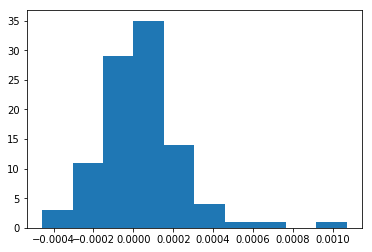

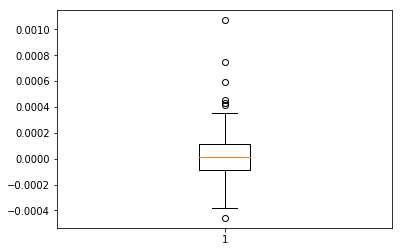

In [50]:
lrclf = LogisticRegression(max_iter=5000,C=1e21)
meclf = MaxEntropy()

lrclf.fit(X_train[:,:-1], y_train)
y_pred_lr = lrclf.predict(X_test[:,:-1])
y_proba_lr= lrclf.predict_proba(X_test[:,:-1])[:,1]

meclf.fit(X_train, y_train)
y_pred_me = meclf.predict(X_test)
y_proba_me = meclf.predict_proba(X_test)

res.loc['logreg sexe','corr sexe'] = np.corrcoef(X_test[:,-1]-np.mean(X_test[:,-1]),y_pred_lr)[0,1]
res.loc['logreg sexe','corr proba +'] = np.corrcoef(X_test[:,-1]-np.mean(X_test[:,-1]),y_proba_lr)[0,1]
res.loc['logreg sexe','accuracy'] = accuracy_score(y_test,y_pred_lr)

res.loc['maxent sexe','corr sexe'] = np.corrcoef(X_test[:,-1]-np.mean(X_test[:,-1]),y_pred_me)[0,1]
res.loc['maxent sexe','corr proba +'] = np.corrcoef(X_test[:,-1]-np.mean(X_test[:,-1]),y_proba_me)[0,1]
res.loc['maxent sexe','accuracy'] = accuracy_score(y_test,y_pred_me)


print(stats.shapiro(y_proba_lr-y_proba_me))
print(stats.ttest_rel(y_proba_lr[:150],y_proba_me[:150]))
plt.figure()
plt.hist(y_proba_lr-y_proba_me)
#plt.savefig('diffnormallydist.png')
plt.show()

plt.figure() 
plt.boxplot(y_proba_lr-y_proba_me)
plt.savefig('boxplotdiff.png')
plt.show()



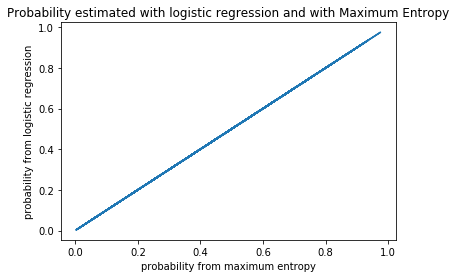

In [55]:
plt.figure()
plt.title('Probability estimated with logistic regression and with Maximum Entropy')
plt.plot(y_proba_me,y_proba_lr)
plt.xlabel('probability from maximum entropy')
plt.ylabel('probability from logistic regression')
plt.savefig(gdir+'probame_vs_probalr.png',bbox_inches='tight')


In [52]:
print("Correlation between probabilities from both classifiers : {} ".format(correlation(y_proba_me,y_proba_lr)[0,0]))

Correlation between probabilities from both classifiers : 0.9999997289846806 
